In [1]:

from tensorflow import keras
from keras import layers
from keras import optimizers
from keras.models import Model
from sklearn.utils import shuffle
import random
from sklearn.model_selection import train_test_split
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import cv2
from keras.metrics import Precision, Recall, AUC

In [2]:

images_dir = 'train_data'
file_names = listdir(images_dir)
sample_count = len(file_names)
print(sample_count)

800


In [3]:
images_dir1 = 'real_data'
file_names1 = listdir(images_dir1)
sample_count1 = len(file_names1)
print(sample_count1)

10


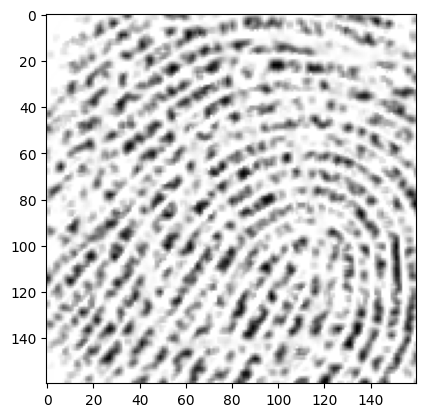

In [4]:

first_image = cv2.imread(images_dir + '/' + file_names[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(first_image, cmap='gray')
height, width = first_image.shape

In [5]:

depth = 1
X = np.zeros((sample_count, width, height, depth))
y = np.zeros((sample_count, 1), dtype=int)
for index, file_name in enumerate(file_names):
 full_path = images_dir + '/' + file_name
 file_label_text, file_number_and_ext = file_name.split('_')
 image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
 label = int(file_label_text)
 X[index] = np.reshape(image, (width, height, depth))
 y[index] = label


X_real = np.zeros((sample_count1, width, height, depth))
y_real = np.zeros((sample_count1, 1), dtype=int)
for index, file_name1 in enumerate(file_names1):
 full_path1 = images_dir1 + '/' + file_name1
 file_label_text1, file_number_and_ext1 = file_name1.split('.')
 image1 = cv2.imread(full_path1, cv2.IMREAD_GRAYSCALE)
 label1 = int(file_label_text1)
 X_real[index] = np.reshape(image1, (width, height, depth))
 y_real[index] = label1

print(X.shape, y.shape)
print(X_real.shape, y_real.shape)

(800, 160, 160, 1) (800, 1)
(10, 160, 160, 1) (10, 1)


In [6]:

img_train, img_val, label_train, label_val = train_test_split(X, y, test_size = 0.1)
print(X.shape, y.shape)
print(img_train.shape, label_train.shape)
print(img_val.shape, label_val.shape)

(800, 160, 160, 1) (800, 1)
(720, 160, 160, 1) (720, 1)
(80, 160, 160, 1) (80, 1)


In [7]:

def build_model():
    x1 = layers.Input(shape = (160, 160, 1))
    x2 = layers.Input(shape = (160, 160, 1))

    inputs = layers.Input(shape = (160, 160, 1))
    feature = layers.Conv2D(32, kernel_size = 3, activation = 'relu')(inputs)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(64, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature_model = Model(inputs = inputs, outputs = feature)

    feature_model.summary()

    x1_net = feature_model(x1)
    x2_net = feature_model(x2)

    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(net)
    net = layers.MaxPooling2D(pool_size = 2)(net)
    net = layers.Flatten()(net)
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(512, activation = 'relu')(net)
    net = layers.Dense(1, activation = 'sigmoid')(net)
    model = Model(inputs = [x1, x2], outputs = net)

    model.compile(loss = 'binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy', Precision(), Recall(), AUC()])
    model.summary()

    return (model, feature_model)

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, img_real, label_real, batch_size = 32, shuffle = True):
        'Initialization'
        self.img_data = img_data
        self.label_data = label_data
        self.img_real = img_real
        self.label_real = label_real
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        'Generate one batch of data'
        real_idx = index
        index = int(np.floor(index / 2))
        img1_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label1_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]
        img2_batch = np.empty((self.batch_size, 160, 160, 1), dtype = np.float32)
        label2_batch = np.zeros((self.batch_size, 1), dtype = np.float32)

        for i, idx in enumerate(label1_batch):
            if random.random() > 0.5:
                img2_batch[i] = self.img_real[idx]
                label2_batch[i] = 1.
            else:
                while True:
                    unmatch_idx = random.choice(list(self.label_real))
                    if (unmatch_idx != idx):
                        break
                img2_batch[i] = self.img_real[unmatch_idx]
                label2_batch[i] = 0.
                
        index = real_idx
        if (index < int(np.floor(len(self.img_data) / self.batch_size))):
            return [img1_batch.astype(np.float32) / 255., img2_batch.astype(np.float32) / 255.], label2_batch
        
        return [img2_batch.astype(np.float32) / 255., img1_batch.astype(np.float32) / 255.], label2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)

In [9]:
train_gen = DataGenerator(img_train, label_train, X_real, y_real, shuffle = True)
val_gen = DataGenerator(img_val, label_val, X_real, y_real, shuffle = True)

In [10]:
(model, feature_model) = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856 

In [11]:
history = model.fit(train_gen, epochs = 5, validation_data = val_gen)

Epoch 1/5
44/44 [==============================] - 93s 2s/step - loss: 0.7078 - accuracy: 0.5135 - precision: 0.5149 - recall: 0.8375 - auc: 0.4831 - val_loss: 0.6948 - val_accuracy: 0.4219 - val_precision: 0.4219 - val_recall: 1.0000 - val_auc: 0.5013
Epoch 2/5
44/44 [==============================] - 94s 2s/step - loss: 0.6889 - accuracy: 0.5526 - precision: 0.5399 - recall: 0.8700 - auc: 0.5479 - val_loss: 0.6807 - val_accuracy: 0.6172 - val_precision: 0.7037 - val_recall: 0.3167 - val_auc: 0.6113
Epoch 3/5
44/44 [==============================] - 89s 2s/step - loss: 0.6772 - accuracy: 0.5703 - precision: 0.5699 - recall: 0.6467 - auc: 0.5877 - val_loss: 0.6346 - val_accuracy: 0.6641 - val_precision: 0.6705 - val_recall: 0.8082 - val_auc: 0.7294
Epoch 4/5
44/44 [==============================] - 94s 2s/step - loss: 0.6682 - accuracy: 0.6143 - precision: 0.6021 - recall: 0.6514 - auc: 0.6408 - val_loss: 0.6584 - val_accuracy: 0.5859 - val_precision: 0.4906 - val_recall: 0.5000 - val_

In [12]:

print('Loss = ', history.history['loss'][39])
print('Accuracy = ', history.history['accuracy'][39])
print('AUC = ', history.history['auc'][39])
print('Precision = ', history.history['precision'][39])
print('Recall = ', history.history['recall'][39])


IndexError: list index out of range

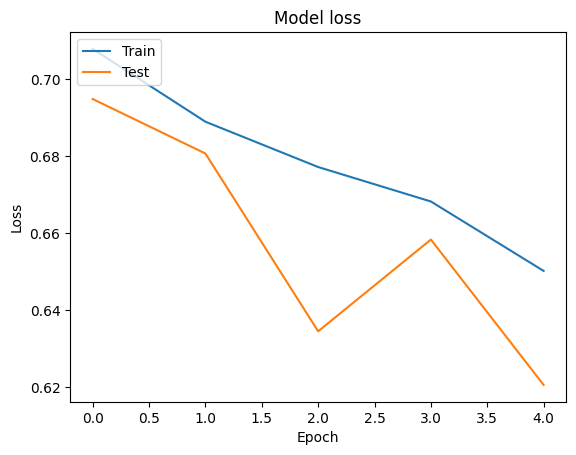

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

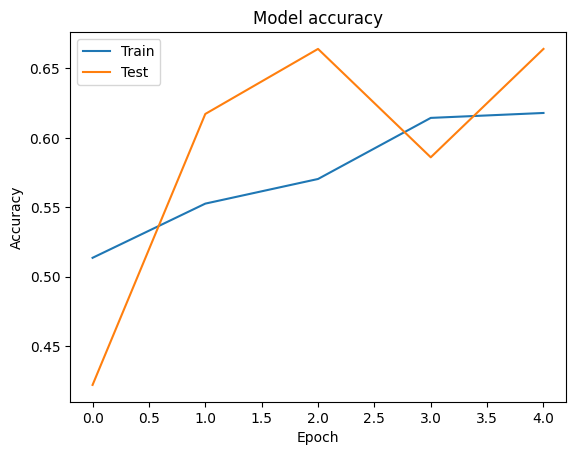

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 306ms/step


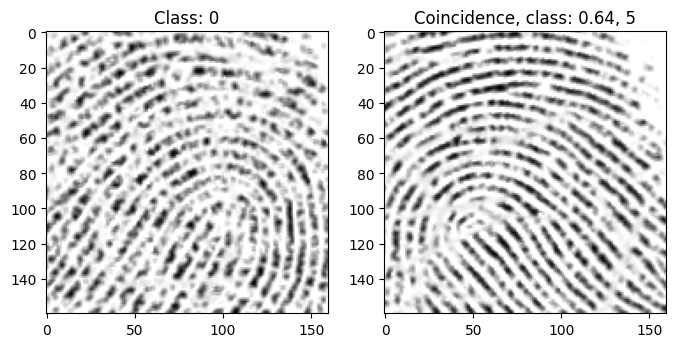

In [15]:
input_idx = 0
db_idx = 5
input_img = X_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
db_img = X_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
pred_right = model.predict([input_img, db_img])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Class: %s' %input_idx)
plt.imshow(input_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Coincidence, class: %.02f, %s' % (pred_right, db_idx))
plt.imshow(db_img.squeeze(), cmap='gray')

1/1 [==============================] - 0s 59ms/step


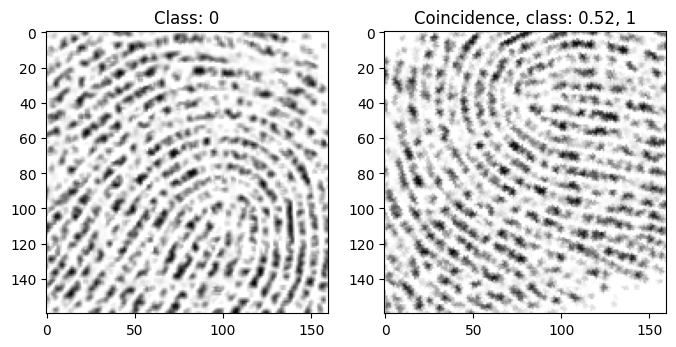

In [ ]:
input_idx = 0
db_idx = 1
input_img = X_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
db_img = X[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
pred_right = model.predict([input_img, db_img])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Class: %s' %input_idx)
plt.imshow(input_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Coincidence, class: %.02f, %s' % (pred_right, db_idx))
plt.imshow(db_img.squeeze(), cmap='gray')

In [ ]:
total_count = 0
error_count = 0
error_rage = 0.5
for input_idx in range(y_real.shape[0]):
    for db_idx in range(80):
        i = 80 * input_idx + db_idx
        input_img = X_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        db_img = X[i].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        pred_right = model.predict([input_img, db_img])
        if (pred_right < error_rage):
            error_count += 1
        total_count += 1

print('Total Count = ', total_count)
print('Error Count = ', error_count)
print('Error Rate = ', (error_count / total_count))

1/1 [==============================] - 0s 38ms/step
Total Count =  800
Error Count =  356
Error Rate =  0.445
